# Week 4 Mini Project: RNN Disaster Tweets Classification

By: Jaeyoung Oh

Repo: https://github.com/BlueJayVRStudio/CSCA5642_Week4

## Problem Statement

The objective of this week's mini project is to classify the context of Tweets. It is a simple binary classification between whether it is about real disasters or not. The set of data consists of a training set and a test set. The test set is reserved only for submission and not validation. The training set consists of 7613 hand-classified data points each composed of ID, keyword, location, body of text and target label. We will first explore keyword, location and text body to identify potential input columns and then perform necessary preprocessing steps on the selected input.

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


ID has no special meaning, so we can easily drop ID from the dataset. Additionally, there are too many null values in keyword and location. Keyword is selected word from the text so it is redudant information. Although location might provide some special context, there are too many null values and does not contain too much meaning. Therefore, we really only need to consider the text bodies as our input column. 

Now we will do some basic NLP preprocessing. *Here are some considerations*:
1. Most NLP tasks favor removing stop words and porter stemming, but for complex context dependent tasks like identifying real disaster in a tweet, preservation of stop words and suffixes may be quintessential especially taking into account the fact that RNN's can discern sequential/temporal patterns.
2. Because RNN learns sequential information, we have to use word tokens as opposed to vectors. We may also use a pretrained word embedding such as Word2Vec.
3. URL's don't provide enough contextual clues and unnecessarily increase complexity. Thus, we can easily decide to remove URL's.
4. For similar reason to removing URL's we can convert all texts to lowercase.

In [5]:
import re

def clean_text(text):
    # remove url's (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # convert to lowercase
    text = text.lower()
    return text

# for extra testing, we can try removing stopwords and suffixes as well
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text_V1(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)
    

In [6]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


Next we look at class distribution to make sure there isn't too much class imbalance:

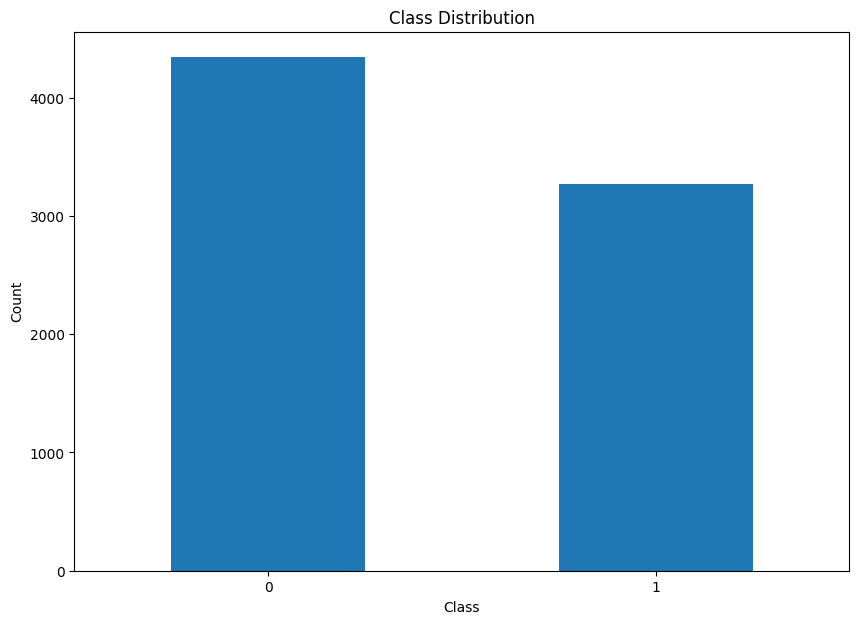

In [110]:
def plot_class_distribution(labels):
    class_counts = labels.value_counts()
    
    plt.figure(figsize=(10, 7))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

plot_class_distribution(train_df['target'])

## Model Building

In [60]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore")

In [61]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

Num GPUs Available: 1


In [62]:
word2vec = KeyedVectors.load_word2vec_format('./embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [63]:
# maximum number of words in a text
max_sequence_length = 50  
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(train_df['text'])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')

# train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences_train, train_df['target'], test_size=0.2, random_state=0)

In [64]:
# test set for submission
sequences_test = tokenizer.texts_to_sequences(test_df['text'])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

In [65]:
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

# embedding_matrix

In [66]:
# build LSTM model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    LSTM(32, return_sequences=False, trainable=True),
    # Dropout(0.2),
    Dense(32, activation='relu', trainable=True),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 lstm_1 (LSTM)               (None, 32)                42624     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5471913 (20.87 MB)
Trainable params: 43713 (170.75 KB)
Non-trainable params: 5428200 (20.71 MB)
_________________________________________________________________


In [67]:
# for layer in model.layers:
#     print(layer)

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [69]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=30, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/30
191/191 [==============================] - 6s 17ms/step - loss: 0.6927 - accuracy: 0.5617 - val_loss: 0.6918 - val_accuracy: 0.5817
Epoch 2/30
191/191 [==============================] - 3s 14ms/step - loss: 0.6911 - accuracy: 0.5675 - val_loss: 0.6890 - val_accuracy: 0.5817
Epoch 3/30
191/191 [==============================] - 3s 14ms/step - loss: 0.6776 - accuracy: 0.5693 - val_loss: 0.6425 - val_accuracy: 0.5982
Epoch 4/30
191/191 [==============================] - 3s 14ms/step - loss: 0.6114 - accuracy: 0.7120 - val_loss: 0.5811 - val_accuracy: 0.7695
Epoch 5/30
191/191 [==============================] - 3s 13ms/step - loss: 0.5717 - accuracy: 0.7777 - val_loss: 0.5594 - val_accuracy: 0.7774
Epoch 6/30
191/191 [==============================] - 2s 13ms/step - loss: 0.5502 - accuracy: 0.7814 - val_loss: 0.5453 - val_accuracy: 0.7748
Epoch 7/30
191/191 [==============================] - 3s 13ms/step - loss: 0.5322 - accuracy: 0.7852 - val_loss: 0.5322 - val_accuracy: 0.7715

In [70]:
def plot_accuracy(hist, name):
    hist_train = hist.history['accuracy']
    hist_val = hist.history['val_accuracy']

    plt.figure(figsize=(11, 7))

    plt.plot(range(len(hist_train)), hist_train, marker='o', label = 'accuracy, training')
    plt.plot(range(len(hist_train)), hist_val, marker='o', label = 'accuracy, validation')
    
    plt.xticks(range(len(hist_train)), range(len(hist_train)), rotation=45)
    
    plt.legend() 
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(name)
    plt.grid(True)
    plt.show()

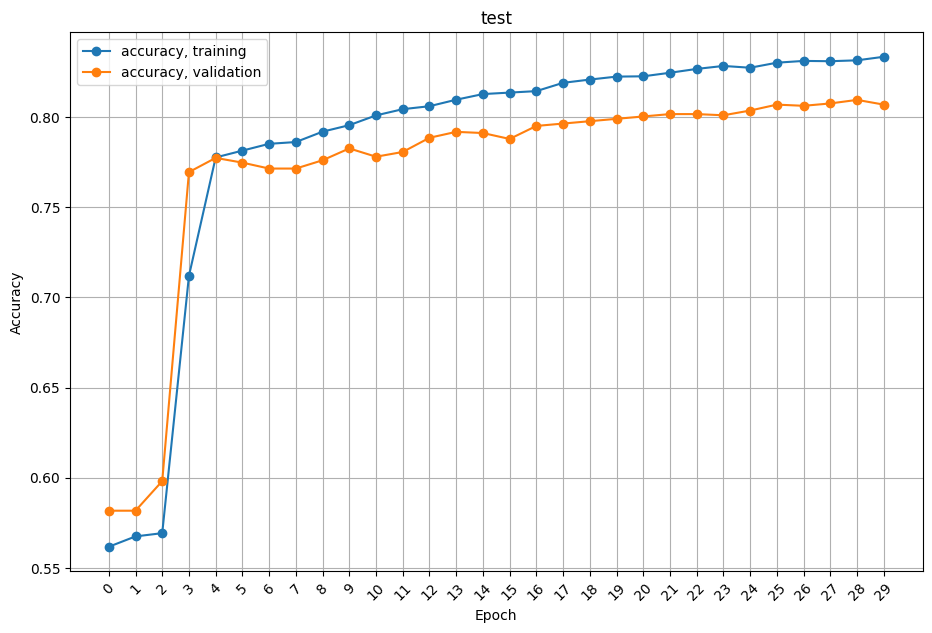

In [71]:
plot_accuracy(history, "test")

In [72]:
# save submission
y_test_pred = model.predict(padded_sequences_test)
y_test_pred

102/102 [==============================] - 1s 6ms/step


array([[0.87813336],
       [0.64021873],
       [0.89303356],
       ...,
       [0.89649487],
       [0.5425272 ],
       [0.5755964 ]], dtype=float32)

In [76]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/submission_RNN_1.csv", index=False)
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## Try Transformers

In [77]:
# import os
# os.environ['TF_USE_LEGACY_KERAS'] = '1'
from transformers import BertTokenizer, TFBertForSequenceClassification


In [78]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], 
    train_df['target'],
    test_size=0.2,
    random_state=0
)

In [79]:
# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize the training and validation texts
train_encodings = tokenizer(
    list(train_texts),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf' 
)

val_encodings = tokenizer(
    list(val_texts),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_encodings = tokenizer(
    list(test_df['text']),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf' 
)

In [80]:
# convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels.tolist())
val_labels = tf.convert_to_tensor(val_labels.tolist())

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}
)).batch(32)

In [104]:
# load and compile BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6,epsilon=1e-04)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_311 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
for layer in model.layers:
    print(layer.name, layer.trainable)
    

bert True
dropout_311 True
classifier True


In [106]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2e-06>

In [107]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
191/191 [==============================] - 76s 230ms/step - loss: 0.6709 - accuracy: 0.5708 - val_loss: 0.6293 - val_accuracy: 0.6014
Epoch 2/20
191/191 [==============================] - 38s 197ms/step - loss: 0.5939 - accuracy: 0.6759 - val_loss: 0.5353 - val_accuracy: 0.7754
Epoch 3/20
191/191 [==============================] - 39s 204ms/step - loss: 0.5035 - accuracy: 0.7823 - val_loss: 0.4623 - val_accuracy: 0.8181
Epoch 4/20
191/191 [==============================] - 39s 203ms/step - loss: 0.4423 - accuracy: 0.8205 - val_loss: 0.4302 - val_accuracy: 0.8299
Epoch 5/20
191/191 [==============================] - 37s 196ms/step - loss: 0.4046 - accuracy: 0.8386 - val_loss: 0.4169 - val_accuracy: 0.8339
Epoch 6/20
191/191 [==============================] - 38s 198ms/step - loss: 0.3792 - accuracy: 0.8506 - val_loss: 0.4158 - val_accuracy: 0.8332
Epoch 7/20
191/191 [==============================] - 38s 199ms/step - loss: 0.3605 - accuracy: 0.8581 - val_loss: 0.4142 - val_ac

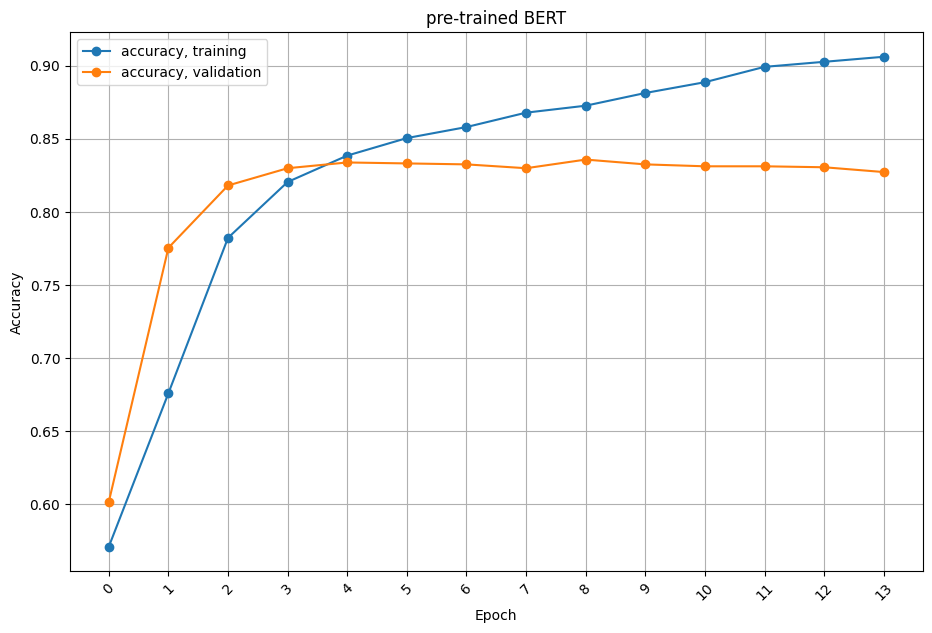

In [109]:
plot_accuracy(history, "pre-trained BERT")

In [102]:
predictions = model.predict(test_dataset)
probabilities = tf.nn.sigmoid(predictions.logits)
predicted_classes = tf.cast(probabilities > 0.5, dtype=tf.int32)

102/102 [==============================] - 9s 85ms/step


In [103]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = np.array(predicted_classes)

submission_df.to_csv("./submissions/submission_pretrained_BERT_confirmed_submission.csv", index=False)
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [38]:
from transformers import BertConfig, TFBertForSequenceClassification, BertTokenizerFast

config = BertConfig(
    vocab_size=30522,  
    hidden_size=8, 
    num_hidden_layers=2, 
    num_attention_heads=4, 
    intermediate_size=8, 
    max_position_embeddings=512,
    num_labels=1
)

model = TFBertForSequenceClassification(config)

model.build()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  249304    
                                                                 
 dropout_121 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  9         
                                                                 
Total params: 249313 (973.88 KB)
Trainable params: 249313 (973.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    # callbacks=[early_stopping]
)

In [325]:
predictions = model.predict(test_dataset)
probabilities = tf.nn.sigmoid(predictions.logits)
predicted_classes = tf.cast(probabilities > 0.5, dtype=tf.int32)

102/102 [==============================] - 7s 53ms/step


In [326]:
np.array(predicted_classes)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [327]:
submission_df = pd.DataFrame()

In [328]:
submission_df['id'] = test_df['id']
submission_df['target'] = np.array(predicted_classes)

In [329]:
submission_df.to_csv("./submissions/submission.csv", index=False)
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
